In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta

In [4]:
from dateutil.relativedelta import *
from dateutil.easter import *
from dateutil.rrule import *
from dateutil.parser import *
from datetime import *

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# Exploratory Climate Analysis

In [11]:
# data type
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# data within table
data = session.query(Measurement).first()
data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x104790908>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [13]:
# latest date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [14]:
# Substract one year to latest date
# because latest date is a string, it must be converted to date dtype
oneyr_behind = (dt.datetime.strptime(latest_date[0], '%Y-%m-%d') - dt.timedelta(days=365)).date()
oneyr_behind

datetime.date(2016, 8, 23)

In [15]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]

oneyr_data = session.query(*sel).\
    filter(func.strftime(Measurement.date >= oneyr_behind)).\
    order_by(Measurement.date).all()

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
date_prcp_df = pd.DataFrame(oneyr_data, columns = ['date', 'prcp'])
date_prcp_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


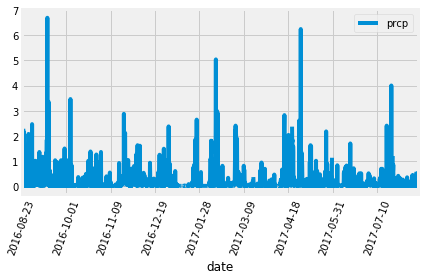

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
date_prcp_df = pd.DataFrame(oneyr_data, columns=['date', 'prcp'])
date_prcp_df.set_index('date', inplace = True)
date_prcp_df.plot(x_compat = True)
plt.xticks(rotation = 70)
plt.tight_layout()
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
avail_stations = session.query(Measurement).group_by('station').count()
print(f"Total number of available stations:  {avail_stations}")

Total number of available stations:  9


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest_temp = session.query(Measurement.station, func.min(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by((Measurement.tobs).desc()).all()
lowest_temp

[('USC00513117', 59.0),
 ('USC00514830', 58.0),
 ('USC00516128', 58.0),
 ('USC00517948', 58.0),
 ('USC00518838', 58.0),
 ('USC00519397', 56.0),
 ('USC00519523', 56.0),
 ('USC00519281', 54.0),
 ('USC00511918', 53.0)]

In [22]:
max_temp = session.query(Measurement.station, func.max(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by((Measurement.tobs).desc()).all()
max_temp

[('USC00511918', 87.0),
 ('USC00517948', 87.0),
 ('USC00519397', 87.0),
 ('USC00513117', 85.0),
 ('USC00514830', 85.0),
 ('USC00519281', 85.0),
 ('USC00519523', 85.0),
 ('USC00516128', 84.0),
 ('USC00518838', 83.0)]

In [23]:
avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by((Measurement.tobs).desc()).all()
avg_temp

[('USC00517948', 74.68440233236151),
 ('USC00519523', 74.5436493068565),
 ('USC00516128', 70.91500765696784),
 ('USC00518838', 72.72407045009784),
 ('USC00519281', 71.66378066378067),
 ('USC00513117', 72.68918420081211),
 ('USC00514830', 74.8732970027248),
 ('USC00511918', 71.61596766043456),
 ('USC00519397', 74.55323054331865)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel_most_active_station = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).limit(1)[0][0]
sel_most_active_station

'USC00519281'

In [25]:
temp = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
most_active_station = session.query(*temp).filter(Measurement.station == sel_most_active_station).all()
most_active_station

[(54.0, 85.0, 71.66378066378067)]

In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.tobs).\
            filter(Measurement.station == sel_most_active_station).\
            filter(Measurement.date >= oneyr_behind).\
            order_by(Measurement.date.desc()).all()
temp_obs_df = pd.DataFrame(temp_obs)
temp_obs_df.head()

,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


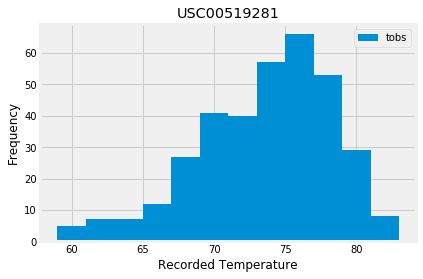

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(temp_obs_df['tobs'], bins=12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title(sel_most_active_station)
plt.legend(["tobs"])
plt.show()

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_mam = calc_temps('2011-08-23', '2012-08-23')
temp_info = temp_mam[0]
temp_info

(56.0, 72.34107076001497, 86.0)

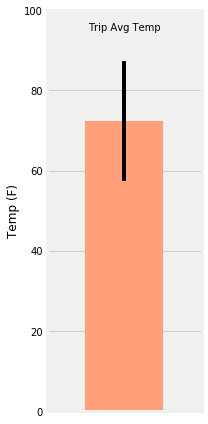

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_min = temp_info[0]
temp_avg = temp_info[1]
temp_max = temp_info[2]
x = 0
y_error_bar = round(temp_max - temp_min, 0)
fig,ax = plt.subplots(figsize=(3, 6))

plt.bar(x, temp_avg, width=.25, yerr=.5*(y_error_bar), alpha=.9999, color='lightsalmon')

plt.ylabel('Temp (F)')
ax.text(.5, .95, 'Trip Avg Temp',
        horizontalalignment = 'center',
        transform = ax.transAxes)
plt.ylim(0, 100)
plt.xlim(-.25, .25)
ax.set_xticklabels([])
plt.grid(False, axis = "x")
plt.savefig("Resources/trip_avg_temp.png")
plt.tight_layout()
plt.show()